In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import numpy as np

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

from architectures import ClicCNN, ClicHyperVAECNN, ClicLadderCNN
from experiment import clic_input_fn
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data

from sampling import IntervalTree, a_star_sample_codable, normal_normal_log_diff, normal_normal_region_bound

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# ==============================================================================
# Predefined Stuff
# ==============================================================================

models = {
    "cnn": ClicCNN,
    "hyper_cnn": ClicHyperVAECNN,
    "ladder_cnn": ClicLadderCNN
}


optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=False),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [3]:
!ls /home/gf332/miracle-models

hyper_cnn_gauss_gauss_prior  hyper_cnn_laplace	ladder_cnn_laplace_gauss_prior


In [4]:
model_key="hyper_cnn"
model_dir="/home/gf332/miracle-models/hyper_cnn_gauss_gauss_prior"
config_path=None
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================

config = {
        "training_set_size": 93085,
        "pixels_per_training_image": 256 * 256 * 3,
        
        # When using VALID for the hierarchical VAEs, this will give the correct
        # latent size
        "image_size": [256, 256],

        "batch_size": 8,
        "num_epochs": 20,
        
        "first_level_channels": 192,
        "second_level_channels": 128,
        "first_level_layers": 4,

        "loss": "nll_perceptual_kl",
        "likelihood": "gaussian",
        "prior": "gaussian",
        
        # % of the number of batches when the coefficient is capped out 
        # (i.e. for 1., the coef caps after the first epoch exactly)
        "warmup": 2., 
        "beta": 0.1,
        "gamma": 0.,
        "learning_rate": 3e-5,
        "optimizer": "adam",

        "log_freq": 50,
        "checkpoint_name": "_ckpt",
    }

if config_path is not None:
    config = json.load(config_path)

# ==========================================================================
# Create VAE model
# ==========================================================================

with tf.device("CPU:0"):
    model = models[model_key]

    if model_key == "cnn":
        vae = model(prior=config["prior"],
                    likelihood=config["likelihood"],
                    padding="SAME_MIRRORED")
        
    elif model_key in ["hyper_cnn", "ladder_cnn"]:
        vae = model(latent_dist=config["prior"],
                    likelihood=config["likelihood"],
                    first_level_channels=config["first_level_channels"],
                    second_level_channels=config["second_level_channels"],
                    first_level_layers=config["first_level_layers"],
                    padding_first_level="SAME_MIRRORED",
                    padding_second_level="SAME_MIRRORED")

    # Connect the model computational graph by executing a forward-pass
    vae(tf.zeros((1, 256, 256, 3)))

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    trainable_vars = vae.get_all_variables() + (global_step,)
    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /home/gf332/miracle-models/hyper_cnn_gauss_gauss_prior/checkpoints/_ckpt-20, restoring...
Model restored!


In [5]:
train_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/train/"
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(valid_image_paths[0])
    encoded_1 = vae(tf.convert_to_tensor(train_img_1[None, ...]))
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    
    print("KL divergence (log2): {:.2f}".format(vae.kl_divergence.numpy() / np.log(2)))
    print("Last KL (log2): {:.2f}".format(tf.reduce_sum(tfd.kl_divergence(vae._latent_posteriors[0], vae._latent_priors[0]))  / np.log(2)))

MS-SSIM: 0.8812
KL divergence (log2): 36646.36
Last KL (log2): 30082.96


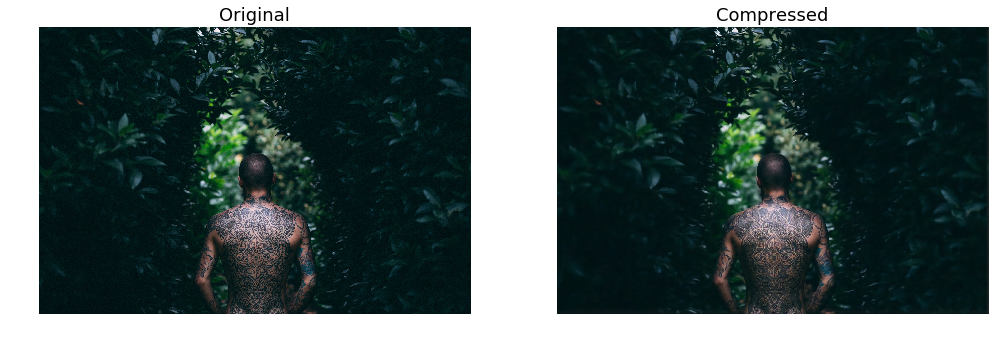

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [7]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/home/gf332/miracle-compession/img/clic/laplace_gauss_ladder2.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

/home/gf332/miracle-compession/img/clic/laplace_gauss_ladder2.png already exists


# Actual compression bit

In [6]:
def coded_sample(prior_loc, prior_scale, post_loc, post_scale, samp_tree):
    
    # Define functions to be used during the sampling procedure
    prop_log_mass = lambda a, b: np.log(norm.cdf(b, loc=prior_loc, scale=prior_scale) - \
                                        norm.cdf(a, loc=prior_loc, scale=prior_scale))
    
    log_diff = lambda x: normal_normal_log_diff(x, prior_loc, prior_scale, post_loc, post_scale)
    
    region_bound = lambda a, b: normal_normal_region_bound(a, 
                                                           b, 
                                                           prior_loc, 
                                                           prior_scale, 
                                                           post_loc, 
                                                           post_scale)
    
    prop_cdf = lambda x: norm.cdf(x, loc=prior_loc, scale=prior_scale)
    prop_inv_cdf = lambda x: norm.ppf(x, loc=prior_loc, scale=prior_scale)
    
    # Draw the sample
    return a_star_sample_codable(prop_log_mass=prop_log_mass, 
                                 log_diff=log_diff, 
                                 samp_tree=samp_tree,
                                 prop_cdf=prop_cdf,
                                 prop_inv_cdf=prop_inv_cdf,
                                 region_bound=region_bound)

In [7]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(valid_image_paths[0])
    res = vae.encode(tf.convert_to_tensor(train_img_1[None, ...]))
    
    res = vae.decode(res, decode_level=2)

In [9]:
# Define constants
num_samples = 2**15

# Get all the stuff we will need to work with

# Prior sufficient statistics
p_mu_2 = vae._latent_priors[1].mean().numpy().flatten()
p_sigma_2 = vae._latent_priors[1].stddev().numpy().flatten()
p_mu_1 = vae._latent_priors[0].mean().numpy().flatten()
p_sigma_1 = vae._latent_priors[0].stddev().numpy().flatten()

# Posterior sufficient statistics
q_mu_2 = vae._latent_posteriors[1].mean().numpy().flatten()
q_sigma_2 = vae._latent_posteriors[1].stddev().numpy().flatten()
q_mu_1 = vae._latent_posteriors[0].mean().numpy().flatten()
q_sigma_1 = vae._latent_posteriors[0].stddev().numpy().flatten()

shape_2 = p_mu_2.shape
shape_1 = p_mu_1.shape

samp_tree = IntervalTree(num_nodes=num_samples)

In [20]:
bad_latents = []
samples = []

np.random.seed(10)

for i in tqdm(range(len(p_mu_2))):
    
    if np.abs(p_mu_2[i] - q_mu_2[i]) / p_sigma_2[i] > 1.:
        bad_latents.append(i)
    else:
        samp = coded_sample(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i], samp_tree)
        
        samples.append(samp)

TypeError: 'NoneType' object is not iterable

In [21]:
bad_latents

[]

In [22]:
samples

[(1.3448476954009205, 0.0, 0),
 (0.010524946701573275, 0.0, 0),
 (6.261335059154176, 0.0, 0),
 (-0.26353207807582124, 0.0, 0),
 (1.0576622545710905, 0.0, 0),
 (2.1045532066435393, 0.0, 0),
 (-1.0675155647653782, 0.0, 0),
 (2.3033867221222093, 0.0, 0),
 (4.145172743146169, 0.0, 0),
 (0.14224083774306098, 0.0, 0),
 (0.8691187193718583, 0.0, 0),
 (1.3283436991793374, -0.6744897501960817, 2),
 (1.6043650954114652, 0.0, 0),
 (1.2171982082600372, 0.0, 0),
 (1.7700055481651966, 0.0, 0),
 (-0.011538792080337208, 0.0, 0),
 (1.7991276765866946, 0.0, 0),
 (2.6514896676935376, 0.0, 0),
 (-0.023799078991569897, 0.0, 0)]

In [11]:
np.percentile(tf.reshape(
    tf.abs(vae._latent_posteriors[0].mean() - vae._latent_priors[0].mean()) / vae._latent_priors[0].stddev(), 
    [-1]).numpy(), 99.99)

3.5071100007759446

In [10]:
np.percentile(tf.abs(vae._latent_posteriors[0].stddev() - vae._latent_priors[0].stddev()).numpy(), 100)

48.21990203857422

In [11]:
tf.reshape(vae._latent_priors[0].stddev(), [-1])[8355]

<tf.Tensor: id=4433, shape=(), dtype=float32, numpy=0.6970889>

In [12]:
bad = vae._latent_posteriors[0].stddev().numpy()[(vae._latent_posteriors[0].mean() > 2.5213994548321015).numpy()]


In [13]:
np.prod(vae._latent_posteriors[0].mean().shape.as_list())

1541760

0.46310884

In [15]:
# Create sampling structure
num_samples_pow = 15

uniform_approx_samp_block = i4_sobol_generate(1, np.power(2, num_samples_pow), skip=10)
normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

normal_tree = IntervalTree(num_nodes)

for i in range(2**num_samples_pow):
    normal_tree.add(normal_approx_samp_block[i, 0])

log_diff = lambda x: normal_normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target)

res = a_star_sample_codable(prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                            log_diff=log_diff, 
                            samp_tree=normal_tree,
                            region_bound=lambda a, b: normal_normal_region_bound(a, 
                                                                                 b, 
                                                                                 mu_prop, 
                                                                                 sigma_prop, 
                                                                                 mu_target, 
                                                                                 sigma_target))

NameError: name 'mu_prop' is not defined

In [23]:
uniform_approx_samp_block = i4_sobol_generate(1, np.power(2, 15), skip=10)
normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

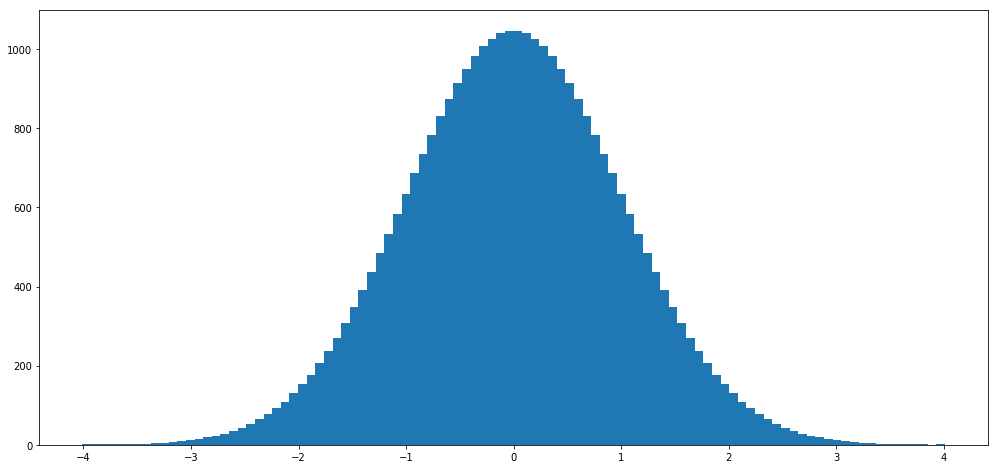

In [24]:
plt.figure(figsize=(17, 8))
plt.hist(normal_approx_samp_block, bins=100)

plt.show()

In [37]:
max(normal_approx_samp_block)

array([4.00877259])

In [26]:
kls = tfd.kl_divergence(vae._latent_posteriors[0], vae._latent_priors[0])

In [34]:
np.percentile(kls.numpy()[(vae._latent_posteriors[0].mean() > 2.5213994548321015).numpy()], )

8.92561453247121

In [35]:
kls = tfd.kl_divergence(vae._latent_posteriors[1], vae._latent_priors[1])

In [36]:
np.max(kls)

5.9019794

In [50]:
help(norm.cdf)

Help on method cdf in module scipy.stats._distn_infrastructure:

cdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Cumulative distribution function of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    cdf : ndarray
        Cumulative distribution function evaluated at `x`

